# Domain wall relaxation in a nanowire

This is a simple example of domain wall relaxation in a nanowire. It shows how to set up a simulation with a rectangular mesh, relax it and then run it in the presence of an applied field. It also shows how to extract the domain wall position and determine the DW velocity.

## Relaxing a trial domain wall

In order to set up and run the simulation we need the following steps:

1. Create a suitable mesh (e.g. a thin film or cylindrical nanowire).

2. Create a simulation object which also encapsulates the material parameters.

3. Run the relaxation

We start by importing some necessary modules. The first commmand `%matplotlib inline` tells the IPython notebook to show any plots in the notebook itself (rather than opening them in a separate window).

In [1]:
%matplotlib inline
from finmag.util.meshes import box, mesh_quality
from finmag import sim_with
from numpy import pi
import os
import sys
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt

[2015-01-21 18:12:02] DEBUG: Building modules in 'native'...
[2015-01-21 18:12:03] DEBUG: FinMag          5721:082de5e831bbce7ce7b04b7cfb2f02fd4909db2e
[2015-01-21 18:12:03] DEBUG: Dolfin          1.4.0                Matplotlib      1.4.0               
[2015-01-21 18:12:03] DEBUG: Numpy           1.8.2                Scipy           0.14.0              
[2015-01-21 18:12:03] DEBUG: IPython         3.0.0-dev            Python          2.7.6               
[2015-01-21 18:12:03] DEBUG: Paraview        4.0.1-1ubuntu1       Sundials        2.5.0               
[2015-01-21 18:12:03] DEBUG: Boost-Python    <unknown>            Linux           Ubuntu 14.04.1 LTS  
[2015-01-21 18:12:03] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


We start by creating a mesh of dimensions `500 nm x 20 nm x 3 nm`. Finmag comes with some predefined mesh creation routines (e.g. `box`, `cylinder`) which we will use here. If you are unsure which arguments they require you can type e.g. "`box?`" in a cell, which will open a help window with the options for the `box` function.

Internally, the command uses `Netgen` to generate the mesh. The argument `maxh` gives an indication of the maximum edge length of the mesh (note that unfortunately `Netgen` only treats this as a rough indication; unfortunately it is not guaranteed that all edges will indeed be smaller than this length).

The argument "`directory='meshes'`" tells the command to save the mesh in a subdirectory called "`meshes`". We could also directly give it a filename, but this way it's easier to deal with multiple meshes (e.g. if we want to experiment with nanowires of different length or thickness).

In [2]:
xmin, xmax = -250, +250
ymin, ymax = 0, 20
zmin, zmax = 0, 3

mesh = box(xmin, ymin, zmin, xmax, ymax, zmax, maxh=3.0, directory='meshes')

[2015-01-21 18:12:03] DEBUG: The mesh '/home/cilix/work/code/finmag/doc/ipython_notebooks_src/meshes/box--250_0-0_0-0_0-250_0-20_0-3_0-3_0.xml.gz' already exists and is automatically returned.


An easy way to get a rough overview of the mesh quality is to use the helper function `mesh_quality` which comes with Finmag. It prints a histogram of edge lengths of the mesh. This makes it easy to get an idea whether they are below the exchange length of the material. In our case most edges are on the order of 0.8 nm long, which is more than sufficient.

In [3]:
print mesh_quality(mesh)

======== Mesh quality info: ========
0.283 
0.318 
0.354 
0.389 
0.424 
0.460 
0.495 
0.530 
0.566 
0.601 **
0.636 **
0.672 **
0.707 *******
0.742 ****************************
0.778 ***************************
0.813 *********************************
0.848 **********************************************************************
0.884 *******************************************************
0.919 *****************************************
0.954 *************************
0.990 **



Next we define a few material parameters which we will use in the simulation. We use values typical of Permalloy. Note that we use a large damping constant `alpha=1.0` in order to speed up the relaxation. For the actual dynamics simulation below we need to set this value to a more realistic value (e.g. `alpha=0.01`).

In [4]:
A = 13e-12   # exchange coupling constant (J/m)
Ms = 8e5     # saturation
alpha = 1.0  # use large damping for relaxation
unit_length = 1e-9  # mesh units are in nanometres

Next we need to define the initial magnetisation profile. We use a `tanh` function to initalise a trial head-to-head domain wall. Let's plot the profile first in order to get a feeling for whether it makes sense. For illustration purposes we use a small offset so that the DW is centred at x=50 and also change the width a little bit.

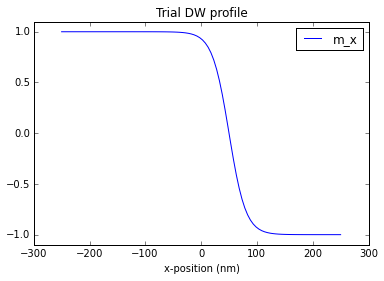

In [5]:
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, -np.tanh((xs - 50.0) / 30.0), label='m_x')
plt.xlabel("x-position (nm)")
plt.title("Trial DW profile")
plt.ylim(-1.1, 1.1)
plt.legend()

This looks reasonable so we'll use it for the simulation. In order to initialise the magnetisation `m` we define a function `m_init` which describes this trial domain wall profile and which we will pass to the simulation below. This function should accept the coordinates of a point in the domain and return the magnetisation at this location. Internally, the simulation will apply this function to all mesh vertices and initialise the magnetisation accordingly.

In [6]:
def m_init(pt):
    x, y, z = pt
    m_x = -np.tanh((x - 50.0) / 30.0)
    m_y = np.sqrt(1 - m_x*m_x)
    m_z = 0.0
    return [m_x, m_y, m_z]

Now we are ready to actually create the simulation object. We simply pass it the mesh, the function `m_init` which defines the initial magnetisation profile as well as the material parameters. (Since we don't use uniaxial anisotropy in this example, we don't set `K1` and `K1_axis`).

In [7]:
sim = sim_with(mesh, m_init=m_init, Ms=Ms, A=A, K1=None, K1_axis=None, alpha=alpha, unit_length=1e-9)

[2015-01-21 18:12:08] INFO: Finmag logging output will be written to file: '/home/cilix/work/code/finmag/doc/ipython_notebooks_src/unnamed.log' (any old content will be overwritten).
[2015-01-21 18:12:08] DEBUG: Creating DataWriter for file 'unnamed.ndt'
[2015-01-21 18:12:08] INFO: Creating Sim object 'unnamed' (rank=0/1).
[2015-01-21 18:12:08] INFO: <Mesh of topological dimension 3 (tetrahedra) with 2716 vertices and 7154 cells, ordered>
[2015-01-21 18:12:08] DEBUG: Creating LLG object.
[2015-01-21 18:12:09] DEBUG: Creating Exchange object with method box-matrix-petsc,  in Jacobian.
[2015-01-21 18:12:09] DEBUG: Adding interaction Exchange to simulation.
[2015-01-21 18:12:09] DEBUG: Creating Demag object with solver 'FK'.
[2015-01-21 18:12:09] DEBUG: Demag parameters now: {'phi_1': {'absolute_tolerance': 1e-06, 'relative_tolerance': 1e-06, 'maximum_iterations': 10000}, 'phi_2': {'absolute_tolerance': 1e-06, 'relative_tolerance': 1e-06, 'maximum_iterations': 10000}, 'phi_2_solver': 'def

A convenient way of visualising the magnetisation is to call the helper function `sim.render_scene()`. This uses Paraview to create a snapshot of the magnetisation. In the example below we adapt a few parameters to "zoom in" near the domain wall. Note that unfortunately there are rare cases in which this does not work (either the resulting image is black or there is an error). In this case it is always possible to save the magnetisation to an external file using `sim.save_vtk` and open it manually in Paraview.

[2015-01-21 18:12:16] INFO: Creating integrator with backend sundials and arguments {'reltol': 1e-06, 'abstol': 1e-06}.
[2015-01-21 18:12:16] DEBUG: Updating get method for steps in TableWriter(name=unnamed.ndt)
[2015-01-21 18:12:16] DEBUG: Updating get method for last_step_dt in TableWriter(name=unnamed.ndt)
[2015-01-21 18:12:16] DEBUG: Updating get method for dmdt in TableWriter(name=unnamed.ndt)
[2015-01-21 18:12:16] DEBUG: Saved field at t=0.0 to file '/tmp/tmpec2HWf/paraview_scene_unnamed.pvd' (snapshot #0; saving took 0.0225 seconds).


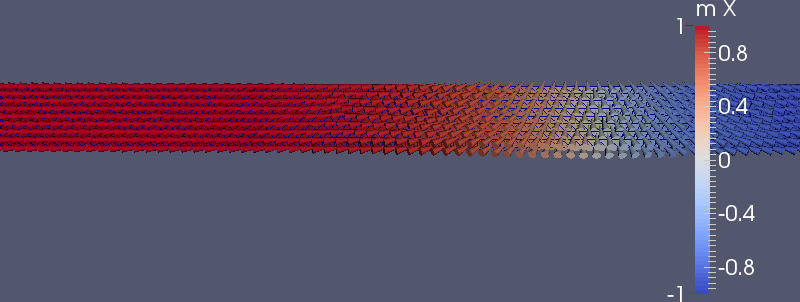

In [8]:
sim.render_scene(camera_position=[0, -200, 200], glyph_scale_factor=2.0, fit_view_to_scene=False)

Next we need to relax the magnetisation. This is achieved by calling `sim.relax()`.

It is convenient to save the relaxed state to a file and reload it when needed (for example, if we want to simulate DW motions starting from the same relaxed state but with applied fields of varying strengths). Therefore we first check whether a file with the relaxed state already exists. If this is not the case, we relax the simulation and save the result. Otherwise we simply reload the relaxed state from that file.

Note that if some of the simulation parameters (e.g. the mesh size or material parameters) are changed then you will need to manually delete the file "`relaxed_state.npz`" and re-run the relaxation).

In [9]:
relaxed_filename = 'relaxed_state.npz'

if not os.path.exists(relaxed_filename):
    #sim.schedule('save_vtk', every=1e-10, filename='snapshots_m_relax/m.pvd', overwrite=True)
    sim.relax()
    sim.save_restart_data(relaxed_filename)
else:
    sim.restart(relaxed_filename)

[2015-01-21 18:12:28] DEBUG: Loading restart data from relaxed_state.npz. 
[2015-01-21 18:12:28] INFO: Creating integrator with backend sundials and arguments {'t0': 3.244548292803764e-10}.
[2015-01-21 18:12:28] INFO: Reloaded and set m (<m>=[  2.00293661e-01   1.00777513e-01   1.13895595e-06]) and time=3.2445482928e-10 from relaxed_state.npz.


Let's visualise the relaxed state, too, to see that indeed it is slightly different from the trial DW profile which we used for initialisation.

[2015-01-21 18:12:34] DEBUG: Saved field at t=3.2445482928e-10 to file '/tmp/tmpsKe5sz/paraview_scene_unnamed.pvd' (snapshot #0; saving took 0.0235 seconds).


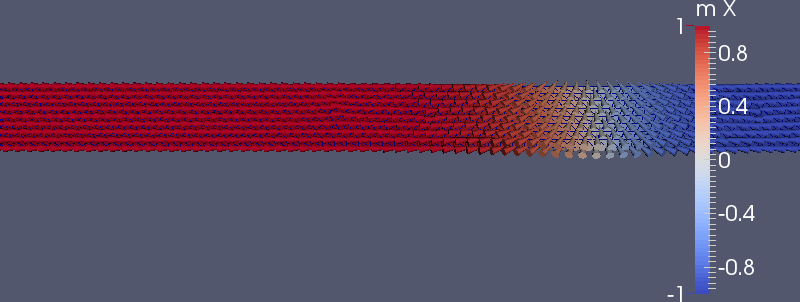

In [10]:
sim.render_scene(camera_position=[0, -200, 200], glyph_scale_factor=2.0, fit_view_to_scene=False)

In order to get a better feeling for the DW profile we can plot the magnetisation components along a line parallel to the x-axis which passes through the centre of the nanowire. We use the function `sim.probe_field_along_line` to probe `m` along such a line and then plot the components `m_x`, `m_y`, `m_z`.

In [11]:
y0 = 0.5 * (ymin + ymax)
z0 = 0.5 * (zmin + zmax)

pts_probed, m_probed = sim.probe_field_along_line('m', [xmin, y0, z0], [xmax, y0, z0], N=1000)

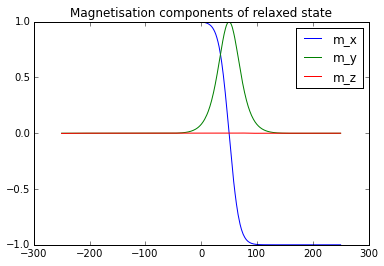

In [12]:
xs = pts_probed[:, 0]
plt.plot(xs, m_probed[:, 0], label='m_x')
plt.plot(xs, m_probed[:, 1], label='m_y')
plt.plot(xs, m_probed[:, 2], label='m_z')
plt.title("Magnetisation components of relaxed state")
plt.legend()

In fact, we can use this same method to extract the domain wall position by checking where `m_x` passes through zero. The following defines a function `domain_wall_centre` which extracts the domain wall position from a simulation object.

In [15]:
class DomainWallError(Exception):
    # It is useful to have a special exception to indicate that
    # something went wrong when computing the domain wall.
    pass


def domain_wall_centre(sim, N=1000):
    coords = sim.mesh.coordinates()
    xmin = coords[:, 0].min()
    xmax = coords[:, 0].max()
    ymin = coords[:, 1].min()
    ymax = coords[:, 1].max()
    zmin = coords[:, 2].min()
    zmax = coords[:, 2].max()
    y0 = 0.5 * (ymin + ymax)
    z0 = 0.5 * (zmin + zmax)
    
    pts_probed, m_probed = sim.probe_field_along_line('m', [xmin, y0, z0], [xmax, y0, z0], N=N)
    xs = np.linspace(xmin, xmax, N)
    m_x = m_probed[:, 0]
    zero_crossings = np.where(np.diff(np.sign(m_x)))[0]
    if len(zero_crossings) >= 2:
        raise DomainWallError("Cannot determine domain wall position (found more than one zero crossing of m_x).")
    elif len(zero_crossings) == 0:
        raise DomainWallError("No domain wall found.")

    idx = zero_crossings[0]  # index just before the zero crossing

    # Return the midpoint of the interval where the zero crossing occurs.
    # This is not 100% exact but we can always increase N to increase
    # the accuracy if desired.
    return 0.5 * (xs[idx] + xs[idx + 1])

When we apply this function to the relaxed simulation we see that indeed the DW is close to the position where we initialised it (x=50 nm).

In [16]:
domain_wall_centre(sim)

50.050050050050061

## DW motion with applied field

Next we run some dynamics with an applied field which pushes the domain wall along the nanowire. In order to do this we first reload the relaxed state again. We already did this above, but it is nice to have the relaxation and dynamic part clearly separated. We also reset the simulation time to 0. This is not strictly necessary but makes the analysis below slightly nicer.

Then we set the damping constant to a smaller value (note that here we use the non-realistic value `alpha=0.5` just to make it run faster; in a real simulation you should use a much smaller value such as 0.01). Finally, we set the strength of the external field.

In [17]:
sim.restart(relaxed_filename)
sim.reset_time(0.0)
sim.alpha = 0.5  # set to a smaller value for real simulations!
sim.set_H_ext([2e4, 0, 0])

[2015-01-21 18:13:32] DEBUG: Loading restart data from relaxed_state.npz. 
[2015-01-21 18:13:32] INFO: Creating integrator with backend sundials and arguments {'t0': 3.244548292803764e-10}.
[2015-01-21 18:13:32] INFO: Reloaded and set m (<m>=[  2.00293661e-01   1.00777513e-01   1.13895595e-06]) and time=3.2445482928e-10 from relaxed_state.npz.
[2015-01-21 18:13:32] INFO: Creating integrator with backend sundials and arguments {'t0': 0.0}.
[2015-01-21 18:13:32] DEBUG: Adding interaction Zeeman to simulation.


Finmag has a convenient way of performing actions at regular intervals during a simulation. This is achieved using the so-called "scheduler" of a simulation object. It comes with some predefined actions (e.g. "save_m") but it can also accept an arbitrary Python function.

We make use of this by defining a function that prints the current domain wall position as well as a function that stores the current simulation time and DW position. Each of these functions should accept a simulation object as its only argument. They cannot return anything, which is why we store the DW positions in a global variable called "`dw_positions`".

In [18]:
def print_domain_wall_centre(sim):
    print "Domain wall centre at t={}: {}".format(sim.t, domain_wall_centre(sim))
    sys.stdout.flush()

In [19]:
dw_positions = []

def record_dw_position(sim):
    """
    Save the current simulation time and domain wall
    position in the global list 'dw_positions'.
    """
    global dw_positions  # tell Python that we want to change the global variable
                        # (otherwise it would think it is a local variable)
    data = (sim.t, domain_wall_centre(sim))
    dw_positions.append(data)

Now that we have defined these functions we can add them to the scheduler by telling it how often to call them (here: every 10e-12 seconds, i.e. every 10 picoseconds of simulation time). We also schedule saving of the magnetisation every 0.1 ns (however, this is only for illustration; we won't use the saved data below).

In [20]:
sim.clear_schedule()
sim.schedule(print_domain_wall_centre, every=10e-12)
sim.schedule(record_dw_position, every=10e-12)
sim.schedule('save_m', every=1e-10, filename='snapshots_m_dynamic/m.npy', overwrite=True)

[2015-01-21 18:13:37] DEBUG: Removing scheduled items:


Now run the simulation for 1 nanosecond (this may take a few minutes to complete). Note how, as the simulation runs, it saves the magnetisation at regular intervals and also prints the current DW position.

In [21]:
sim.run_until(1e-9)

[2015-01-21 18:13:52] INFO: Simulation will run until t = 1e-09 s.


Domain wall centre at t=0.0: 50.0500500501


[2015-01-21 18:13:52] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000000.npy'.


Domain wall centre at t=1e-11: 50.5505505506
Domain wall centre at t=2e-11: 51.5515515516
Domain wall centre at t=3e-11: 52.5525525526
Domain wall centre at t=4e-11: 54.0540540541
Domain wall centre at t=5e-11: 55.0550550551
Domain wall centre at t=6e-11: 56.5565565566
Domain wall centre at t=7e-11: 58.0580580581
Domain wall centre at t=8e-11: 59.5595595596
Domain wall centre at t=9e-11: 61.0610610611
Domain wall centre at t=1e-10: 62.5625625626


[2015-01-21 18:15:10] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000001.npy'.


Domain wall centre at t=1.1e-10: 64.0640640641
Domain wall centre at t=1.2e-10: 65.0650650651
Domain wall centre at t=1.3e-10: 66.5665665666
Domain wall centre at t=1.4e-10: 68.0680680681
Domain wall centre at t=1.5e-10: 69.5695695696
Domain wall centre at t=1.6e-10: 71.0710710711
Domain wall centre at t=1.7e-10: 72.5725725726
Domain wall centre at t=1.8e-10: 74.0740740741
Domain wall centre at t=1.9e-10: 75.5755755756
Domain wall centre at t=2e-10: 77.0770770771


[2015-01-21 18:16:22] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000002.npy'.


Domain wall centre at t=2.1e-10: 78.5785785786
Domain wall centre at t=2.2e-10: 80.0800800801
Domain wall centre at t=2.3e-10: 81.5815815816
Domain wall centre at t=2.4e-10: 82.5825825826
Domain wall centre at t=2.5e-10: 84.0840840841
Domain wall centre at t=2.6e-10: 85.5855855856
Domain wall centre at t=2.7e-10: 87.0870870871
Domain wall centre at t=2.8e-10: 88.5885885886
Domain wall centre at t=2.9e-10: 90.0900900901
Domain wall centre at t=3e-10: 91.5915915916


[2015-01-21 18:18:18] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000003.npy'.


Domain wall centre at t=3.1e-10: 93.0930930931
Domain wall centre at t=3.2e-10: 94.5945945946
Domain wall centre at t=3.3e-10: 96.0960960961
Domain wall centre at t=3.4e-10: 97.5975975976
Domain wall centre at t=3.5e-10: 99.0990990991
Domain wall centre at t=3.6e-10: 100.600600601
Domain wall centre at t=3.7e-10: 101.601601602
Domain wall centre at t=3.8e-10: 103.103103103
Domain wall centre at t=3.9e-10: 104.604604605
Domain wall centre at t=4e-10: 106.106106106


[2015-01-21 18:20:32] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000004.npy'.


Domain wall centre at t=4.1e-10: 107.607607608
Domain wall centre at t=4.2e-10: 109.109109109
Domain wall centre at t=4.3e-10: 110.610610611
Domain wall centre at t=4.4e-10: 112.112112112
Domain wall centre at t=4.5e-10: 113.613613614
Domain wall centre at t=4.6e-10: 115.115115115
Domain wall centre at t=4.7e-10: 116.616616617
Domain wall centre at t=4.8e-10: 118.118118118
Domain wall centre at t=4.9e-10: 119.61961962
Domain wall centre at t=5e-10: 121.121121121


[2015-01-21 18:22:35] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000005.npy'.


Domain wall centre at t=5.1e-10: 122.622622623
Domain wall centre at t=5.2e-10: 123.623623624
Domain wall centre at t=5.3e-10: 125.125125125
Domain wall centre at t=5.4e-10: 126.626626627
Domain wall centre at t=5.5e-10: 128.128128128
Domain wall centre at t=5.6e-10: 129.62962963
Domain wall centre at t=5.7e-10: 131.131131131
Domain wall centre at t=5.8e-10: 132.632632633
Domain wall centre at t=5.9e-10: 134.134134134
Domain wall centre at t=6e-10: 135.635635636


[2015-01-21 18:24:37] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000006.npy'.


Domain wall centre at t=6.1e-10: 137.137137137
Domain wall centre at t=6.2e-10: 138.638638639
Domain wall centre at t=6.3e-10: 140.14014014
Domain wall centre at t=6.4e-10: 141.641641642
Domain wall centre at t=6.5e-10: 143.143143143
Domain wall centre at t=6.6e-10: 144.644644645
Domain wall centre at t=6.7e-10: 146.146146146
Domain wall centre at t=6.8e-10: 147.647647648
Domain wall centre at t=6.9e-10: 149.149149149
Domain wall centre at t=7e-10: 150.650650651


[2015-01-21 18:26:52] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000007.npy'.


Domain wall centre at t=7.1e-10: 151.651651652
Domain wall centre at t=7.2e-10: 153.153153153
Domain wall centre at t=7.3e-10: 154.654654655
Domain wall centre at t=7.4e-10: 156.156156156
Domain wall centre at t=7.5e-10: 157.657657658
Domain wall centre at t=7.6e-10: 159.159159159
Domain wall centre at t=7.7e-10: 160.660660661
Domain wall centre at t=7.8e-10: 162.162162162
Domain wall centre at t=7.9e-10: 163.663663664
Domain wall centre at t=8e-10: 165.165165165


[2015-01-21 18:29:12] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000008.npy'.


Domain wall centre at t=8.1e-10: 166.666666667
Domain wall centre at t=8.2e-10: 168.168168168
Domain wall centre at t=8.3e-10: 169.66966967
Domain wall centre at t=8.4e-10: 171.171171171
Domain wall centre at t=8.5e-10: 172.672672673
Domain wall centre at t=8.6e-10: 174.174174174
Domain wall centre at t=8.7e-10: 175.675675676
Domain wall centre at t=8.8e-10: 177.177177177
Domain wall centre at t=8.9e-10: 178.678678679
Domain wall centre at t=9e-10: 180.18018018


[2015-01-21 18:32:11] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000009.npy'.


Domain wall centre at t=9.1e-10: 181.681681682
Domain wall centre at t=9.2e-10: 183.183183183
Domain wall centre at t=9.3e-10: 185.185185185
Domain wall centre at t=9.4e-10: 186.686686687
Domain wall centre at t=9.5e-10: 188.188188188
Domain wall centre at t=9.6e-10: 189.68968969
Domain wall centre at t=9.7e-10: 191.191191191
Domain wall centre at t=9.8e-10: 192.692692693
Domain wall centre at t=9.9e-10: 194.194194194
Domain wall centre at t=1e-09: 196.196196196


[2015-01-21 18:35:24] DEBUG: Saving field data to file 'snapshots_m_dynamic/m_000010.npy'.
[2015-01-21 18:35:24] INFO: Simulation has reached time t = 1e-09 s.


Once it is finished we can convince us that the list of domain wall positions was indeed populated as intended (we only print the first 10 list elements to avoid a huge amount of output):

In [23]:
dw_positions[:10]

[(0.0, 50.050050050050061),
 (1e-11, 50.550550550550554),
 (2e-11, 51.551551551551597),
 (3e-11, 52.552552552552584),
 (4e-11, 54.054054054054063),
 (4.9999999999999995e-11, 55.055055055055107),
 (6e-11, 56.556556556556586),
 (7e-11, 58.058058058058066),
 (8.000000000000001e-11, 59.559559559559602),
 (9.000000000000001e-11, 61.061061061061082)]

## Plotting the DW position over time and computing the average DW velocity

In order to visualise the domain wall dynamics we extract the simulation times and DW positions from `dw_positions` and plot it.

In [24]:
ts, dw_pos = np.array(dw_positions).T

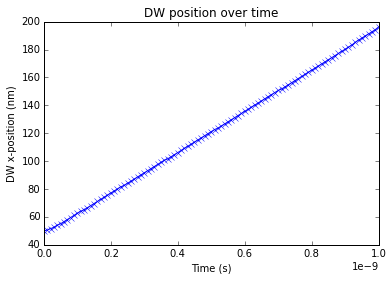

In [26]:
plt.plot(ts, dw_pos, 'x-')
plt.title("DW position over time")
plt.xlabel("Time (s)")
plt.ylabel("DW x-position (nm)")

The average domain wall velocity can easily be computed from the first and last position:

In [27]:
avg_velocity = (dw_pos[-1] - dw_pos[0]) / (ts[-1] - ts[0]) * 1e-9

In [28]:
print("Average domain wall velocity (m/s): {}".format(avg_velocity))

Average domain wall velocity (m/s): 146.146146146
